### Computing a 1D FES from umbrella sampling

Example illustrating the application of MBAR to compute a 1D free energy profile from an umbrella sampling simulation.<br>
The data represents an umbrella sampling simulation for the chi torsion of<br>
a valine sidechain in lysozyme L99A with benzene bound in the cavity.<br>

Reference for data.
    D. L. Mobley, A. P. Graves, J. D. Chodera, A. C. McReynolds, B. K. Shoichet and K. A. Dill,<br>
    "Predicting absolute ligand binding free energies to a simple model site,"<br>
    Journal of Molecular Biology 371(4):1118-1134 (2007).<br>
    http://dx.doi.org/10.1016/j.jmb.2007.06.002<br>


In [1]:
import numpy as np

In [2]:
import pymbar  # multistate Bennett acceptance ratio
from pymbar import timeseries  # timeseries analysis
import matplotlib.pyplot as plt

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



Constants.

In [3]:
kB = 1.381e-23 * 6.022e23 / 1000.0  # Boltzmann constant in kJ/mol/K

In [4]:
temperature = 300  # assume a single temperature -- can be overridden with data from center.dat

Parameters for the data collected. 

In [5]:
K = 26  # number of umbrellas
N_max = 501  # maximum number of snapshots/simulation
T_k = np.ones(K, float) * temperature  # inital temperatures are all equal
beta = 1.0 / (kB * temperature)  # inverse temperature of simulations (in 1/(kJ/mol))
chi_min = -180.0  # min for free energy profile
chi_max = +180.0  # max for free energy profile
nbins = 36  # number of bins for 1D free energy profile

Allocate storage for simulation data<br>
N_k[k] is the number of snapshots from umbrella simulation $k$

In [6]:
N_k = np.zeros([K], dtype=int)
# K_k[k] is the spring constant (in kJ/mol/deg**2) for umbrella simulation k
K_k = np.zeros([K])
# chi0_k[k] is the spring center location (in deg) for umbrella simulation k
chi0_k = np.zeros([K])
# chi_kn[k,n] is the torsion angle (in deg) for snapshot n from umbrella simulation k
chi_kn = np.zeros([K, N_max])
# u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
u_kn = np.zeros([K, N_max])
g_k = np.zeros([K])

Read in umbrella spring constants and centers from the provided data file. for this data set, the force constants are not all the same, but the temperatures are. 

In [7]:
with open("data/centers.dat") as infile:
    lines = infile.readlines()

In [8]:
for k in range(K):
    # Parse line k.
    line = lines[k]
    tokens = line.split()
    chi0_k[k] = float(tokens[0])  # spring center location (in deg)
    # spring constant (read in kJ/mol/rad**2, converted to kJ/mol/deg**2)
    K_k[k] = float(tokens[1]) * (np.pi / 180) ** 2
    if len(tokens) > 2:
        T_k[k] = float(tokens[2])  # temperature the kth simulation was run at.

In [9]:
beta_k = 1.0 / (kB * T_k)  # beta factor for the different temperatures
different_temperatures = True
if min(T_k) == max(T_k):
    # if all the temperatures are the same, then we don't have to read in energies.
    different_temperatures = False

Read the simulation data, which is expressed as torsion angles.  We also compute the statistical inefficiency to be able to subsample the data using timeseries.statistical_inefficiency. 

In [10]:
for k in range(K):
    # Read torsion angle data.
    filename = f"data/prod{k:d}_dihed.xvg"
    print(f"Reading {filename}...")
    n = 0
    with open(filename, "r") as infile:
        for line in infile:
            if line[0] != "#" and line[0] != "@":
                tokens = line.split()
                chi = float(tokens[1])  # torsion angle
                # wrap chi_kn to be within [-180,+180)
                while chi < -180.0:
                    chi += 360.0
                while chi >= +180.0:
                    chi -= 360.0
                chi_kn[k, n] = chi
                n += 1
    N_k[k] = n
    if different_temperatures:  # if different temperatures are specified the metadata file,
        # then we need the energies to compute the free energy profile
        # Read energies
        filename = f"data/prod{k:d}_energies.xvg"
        print(f"Reading {filename}...")
        n = 0
        with open(filename, "r") as infile:
            for line in infile:
                if line[0] != "#" and line[0] != "@":
                    tokens = line.split()
                    # reduced potential energy without umbrella restraint
                    u_kn[k, n] = beta_k[k] * (float(tokens[2]) - float(tokens[1]))
                    n += 1

    # Compute correlation times for potential energy and chi
    # timeseries.  If the temperatures differ, use energies to determine samples; otherwise, use the cosine of chi
    if different_temperatures:
        g_k[k] = timeseries.statistical_inefficiency(u_kn[k, :], u_kn[k, 0 : N_k[k]])
        print(f"Correlation time for set {k:5d} is {g_k[k]:10.3f}")
        indices = timeseries.subsample_correlated_data(u_kn[k, 0 : N_k[k]])
    else:
        chi_radians = chi_kn[k, 0 : N_k[k]] / (180.0 / np.pi)
        g_cos = timeseries.statistical_inefficiency(np.cos(chi_radians))
        g_sin = timeseries.statistical_inefficiency(np.sin(chi_radians))
        print(f"g_cos = {g_cos:.1f} | g_sin = {g_sin:.1f}")
        g_k[k] = max(g_cos, g_sin)
        print(f"Correlation time for set {k:5d} is {g_k[k]:10.3f}")
        indices = timeseries.subsample_correlated_data(chi_radians, g=g_k[k])
    # Subsample data.
    N_k[k] = len(indices)
    u_kn[k, 0 : N_k[k]] = u_kn[k, indices]
    chi_kn[k, 0 : N_k[k]] = chi_kn[k, indices]

Reading data/prod0_dihed.xvg...
g_cos = 1.0 | g_sin = 1.2
Correlation time for set     0 is      1.193
Reading data/prod1_dihed.xvg...
g_cos = 1.2 | g_sin = 1.2
Correlation time for set     1 is      1.248
Reading data/prod2_dihed.xvg...
g_cos = 2.6 | g_sin = 2.5
Correlation time for set     2 is      2.550
Reading data/prod3_dihed.xvg...
g_cos = 4.1 | g_sin = 4.1
Correlation time for set     3 is      4.136
Reading data/prod4_dihed.xvg...
g_cos = 1.5 | g_sin = 1.4
Correlation time for set     4 is      1.462
Reading data/prod5_dihed.xvg...
g_cos = 2.5 | g_sin = 1.0
Correlation time for set     5 is      2.471
Reading data/prod6_dihed.xvg...
g_cos = 1.2 | g_sin = 1.4
Correlation time for set     6 is      1.357
Reading data/prod7_dihed.xvg...
g_cos = 1.5 | g_sin = 1.5
Correlation time for set     7 is      1.538
Reading data/prod8_dihed.xvg...
g_cos = 1.6 | g_sin = 1.6
Correlation time for set     8 is      1.584
Reading data/prod9_dihed.xvg...
g_cos = 1.6 | g_sin = 1.6
Correlation tim

In [11]:
N_max = np.max(N_k)  # shorten the array size
# u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kln = np.zeros([K, K, N_max])

Set zero of u_kn -- this is arbitrary. 

In [12]:
u_kn -= u_kn.min()

Compute bin centers

In [13]:
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(chi_min, chi_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])

In [14]:
N = np.sum(N_k)
# convert to 1D representaion of the observables. 
chi_n = pymbar.utils.kn_to_n(chi_kn, N_k=N_k)

Evaluate reduced energies in all umbrellas.  We first compute the smallest distance from the data point to the bin center corresponding to the umbrella $k$, wrapping around the periodic image (this is the minimum data convention), then multiply it times the spring constant of state $k$.

In [15]:
print("Evaluating reduced potential energies...")
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image torsion deviation from umbrella center l
        dchi = chi_kn[k, n] - chi0_k
        for l in range(K):
            if abs(dchi[l]) > 180.0:
                dchi[l] = 360.0 - abs(dchi[l])

        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k, :, n] = u_kn[k, n] + beta_k[k] * (K_k / 2.0) * dchi**2

Evaluating reduced potential energies...


Initialize free energy profile with the data collected.  This is calling MBAR under the hood to determine the weights corresponding to each of the biased samples. 

In [16]:
fes = pymbar.FES(u_kln, N_k, verbose=True)


******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************



Now extract the free energy at the bin centers, and compare it to the free energy of each umbrella.  NOTE that we don't expect them to be exactly the same, since the free energy of a given point is NOT the free energy of the bin center - there are 15 bins, and only 7 umbrellas.

In [17]:
# Compute free energy profile in unbiased potential (in units of kT).
histogram_parameters = {}
histogram_parameters["bin_edges"] = bin_edges
fes.generate_fes(u_kn, chi_n, fes_type="histogram", histogram_parameters=histogram_parameters)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
center_f_i = results["f_i"]
center_df_i = results["df_i"]

Write out free energy profile, with uncertainty. 

In [18]:
print("free energy profile (in units of kT), from histogramming")
print(f"{'bin':>8s} {'umbrella_f':>8s} {'f':>8s} {'df':>8s}")
for i in range(nbins):
    print(f"{bin_center_i[i]:8.1f} {center_f_i[i]:8.3f} {center_df_i[i]:8.3f}")

free energy profile (in units of kT), from histogramming
     bin umbrella_f        f       df
  -175.0    0.889    0.083
  -165.0    3.104    0.131
  -155.0    5.986    0.166
  -145.0    8.875    0.249
  -135.0   11.387    0.275
  -125.0   12.438    0.350
  -115.0   11.830    0.371
  -105.0    9.570    0.374
   -95.0    6.535    0.376
   -85.0    4.123    0.381
   -75.0    2.538    0.386
   -65.0    2.015    0.400
   -55.0    2.586    0.403
   -45.0    3.745    0.409
   -35.0    5.739    0.419
   -25.0    8.190    0.423
   -15.0   11.119    0.425
    -5.0   14.051    0.436
     5.0   15.151    0.432
    15.0   13.669    0.431
    25.0   11.437    0.434
    35.0    8.833    0.436
    45.0    6.711    0.435
    55.0    5.371    0.439
    65.0    5.158    0.416
    75.0    6.132    0.384
    85.0    7.281    0.345
    95.0    8.170    0.318
   105.0    8.602    0.299
   115.0    8.903    0.283
   125.0    8.440    0.270
   135.0    7.413    0.262
   145.0    5.084    0.240
   155.0    2.

And plot it, with estimated uncertainties, generated from analytical estimates of the uncertainty. 

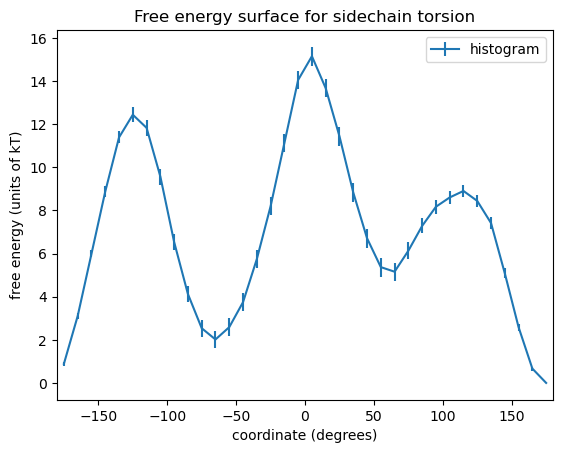

In [19]:
plt.errorbar(bin_center_i, center_f_i, yerr=center_df_i, label='histogram')
plt.title("Free energy surface for sidechain torsion")
plt.ylabel("free energy (units of kT)")
plt.xlabel("coordinate (degrees)")
plt.xlim(-180,180)
plt.legend()
plt.show()

Now compute the same with KDEs. We can compare the histogram free energy with the KDE free energy at each point.  This time we need to specify a bandwidth, i.e, how big the Gaussian is at each point. 

In [20]:
kde_parameters = {}
kde_parameters["bandwidth"] = 0.5 * ((chi_max - chi_min) / nbins)
fes.generate_fes(u_kn, chi_n, fes_type="kde", kde_parameters=kde_parameters)
results = fes.get_fes(bin_center_i, reference_point="from-lowest")
# Write out free energy profile from KDE
kde_center_f_i = results["f_i"]
print("free energy profile (in units of kT), from KDE")
print(f"{'bin':>8s} {'f':>8s}")
for i in range(nbins):
    print(f"{bin_center_i[i]:8.1f} {kde_center_f_i[i]:8.3f}")

free energy profile (in units of kT), from KDE
     bin        f
  -175.0    1.036
  -165.0    2.485
  -155.0    5.007
  -145.0    7.964
  -135.0   10.641
  -125.0   12.021
  -115.0   11.224
  -105.0    8.538
   -95.0    5.709
   -85.0    3.681
   -75.0    2.316
   -65.0    1.862
   -55.0    2.381
   -45.0    3.480
   -35.0    5.183
   -25.0    7.426
   -15.0   10.219
    -5.0   13.136
     5.0   14.577
    15.0   13.090
    25.0   10.631
    35.0    8.063
    45.0    6.234
    55.0    5.167
    65.0    5.061
    75.0    5.842
    85.0    7.035
    95.0    7.890
   105.0    8.400
   115.0    8.598
   125.0    8.141
   135.0    6.726
   145.0    4.295
   155.0    2.044
   165.0    0.430
   175.0    0.000


And plot both of them as a function of torsion angle (for now, we just use the errors for the KDE version)

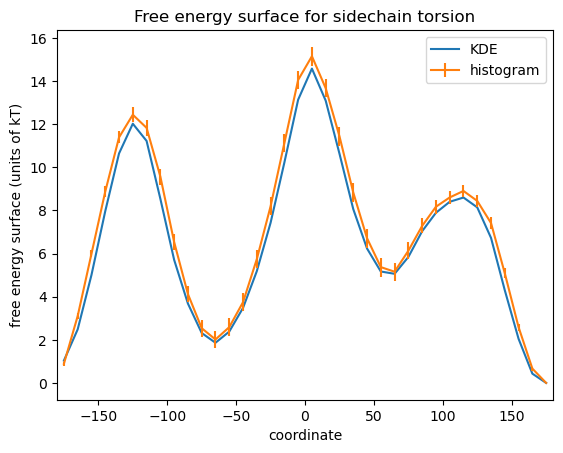

In [21]:
plt.plot(bin_center_i, kde_center_f_i, label='KDE')
plt.errorbar(bin_center_i, center_f_i, yerr=center_df_i, label='histogram')
plt.title("Free energy surface for sidechain torsion")
plt.ylabel("free energy surface (units of kT)")
plt.xlabel("coordinate")
plt.xlim(-180,180)
plt.legend()
plt.show()

They are almost, but not exactly the same. But we don't have to compute at just the bin centers; we can actually print at any value.  Let's evaluate the FES again.  This time, we will use bootstrap sampling, which means we will need to reinitialize by calling bootstraps many times.  We'll turn off verbosity, as it will print the results many times.

How many points do we want to plot? 

In [22]:
xplot = np.linspace(-180,180,1000)

Now generate the free energy surface; note that will take longer, since we are resolving for the $N_{bootstraps}$ free energies.  Note that for good error estimates, we probably want to generate 50-ish bootstrap samples, but I'm using 20 to get to get reasonable close without waiting too long. 

In [23]:
fes.generate_fes(u_kn, chi_n, fes_type="kde", kde_parameters=kde_parameters, n_bootstraps = 20)

{'timing': 0.43416254200565163}

In [24]:
results_kde = fes.get_fes(xplot, reference_point="from-lowest", uncertainty_method="bootstrap")

In [25]:
f_ik = results_kde["f_i"]
df_ik = results_kde["df_i"]

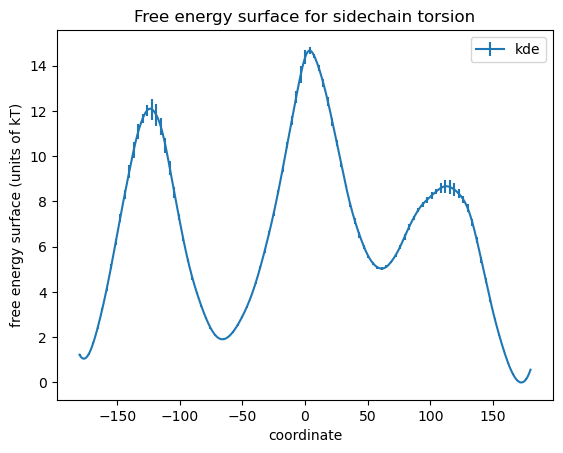

In [26]:
plt.errorbar(xplot, f_ik, yerr=df_ik, label='kde', errorevery=10)
plt.title("Free energy surface for sidechain torsion")
plt.ylabel("free energy surface (units of kT)")
plt.xlabel("coordinate")
plt.legend()
plt.show()

And we can compare to the histogram bootstrapped samples as well. First generate them.

In [27]:
fes.generate_fes(u_kn, chi_n, fes_type="histogram", histogram_parameters=histogram_parameters, n_bootstraps = 20)
results_hist = fes.get_fes(xplot, reference_point="from-lowest", uncertainty_method="bootstrap")


Then plot the two together. 

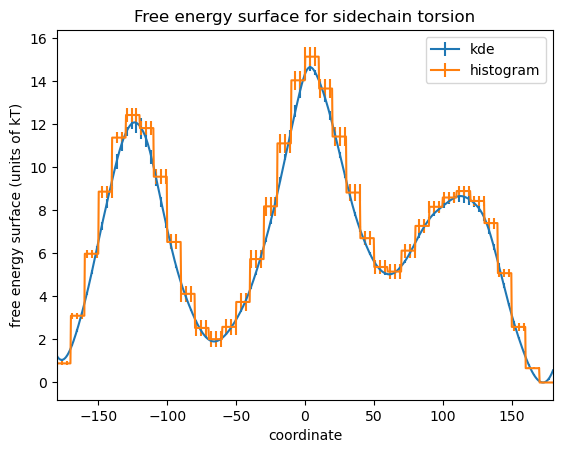

In [28]:
f_ih = results_hist["f_i"]
df_ih = results_hist["df_i"]
plt.errorbar(xplot, f_ik, yerr=df_ik, label='kde', errorevery=10)
plt.errorbar(xplot, f_ih, yerr=df_ih, label='histogram', errorevery=10)
plt.title("Free energy surface for sidechain torsion")
plt.ylabel("free energy surface (units of kT)")
plt.xlabel("coordinate")
plt.xlim(-180,180)
plt.legend()
plt.show()

Note that the histogram FES is actually displayed as a histogram.